<a href="https://colab.research.google.com/github/vaibhatt/Fall_Fest_iNets/blob/main/iNets_CTscan_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import os
from sklearn.model_selection import train_test_split
import seaborn as sns
from pathlib import Path
import cv2
from skimage.transform import pyramid_reduce, resize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [131]:
#data preprocessing
pos_path = "/content/drive/MyDrive/ct scan classification/CT_COVID"
neg_path = "/content/drive/MyDrive/ct scan classification/CT_NonCOVID"

ext_set = set()
for child in Path(pos_path).iterdir():
    ext = Path(child).suffix
    ext_set.add(ext)
print(f'positive image extensions: {ext_set}')

ext_set = set()
for child in Path(neg_path).iterdir():
    ext = Path(child).suffix
    ext_set.add(ext)
print(f'negative image extensions: {ext_set}')

positive image extensions: {'.png'}
negative image extensions: {'.png', '.jpg'}


In [132]:
pos_li = list(Path(pos_path).glob('*.png'))
neg_li = list(Path(neg_path).glob('*.png'))
neg_li.extend(list(Path(neg_path).glob('*.jpg')))

In [133]:
print(f"No. of positive images : {len(pos_li)}")
print(f"No. of negative images : {len(neg_li)}")

No. of positive images : 349
No. of negative images : 397


In [134]:
#Hyper param
lr = 1e-5
IMG_SIZE = 128
BS = 32

In [135]:
pos_data = np.empty((len(pos_li), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
neg_data = np.empty((len(neg_li), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)

In [136]:
# convert images to numpy arrays
## positive
for i, img_path in enumerate(sorted(pos_li)):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    pos_data[i] = img
## negative
for i, img_path in enumerate(sorted(neg_li)):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    neg_data[i] = img

In [137]:
#image scaling
pos_data /= 255
neg_data /= 255
print(pos_data.shape)

(349, 128, 128, 1)


In [138]:
# define function to perform image segmentation with k-means clustering
def k_means(img_array_list, K, criteria, attempts):
    new_img_array_list = []
    for array in img_array_list:
        # flatten array into 2D
        img = array.reshape(-1,1) # reshape into new dimensions; -1 refers to unknown dimension and will depend on others
                                  # (-1,1) will result in 2D with 1 column and n rows where 1 column x n rows is equal to  
                                  # the original number of elements. ex) (10,10) = (5,20) > both with 100 elements
                                  # 1 column is used since it's gray-scale image (3 used for RGB)
        ret, label, center = cv2.kmeans(img, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
#         center = np.uint8(center)
        res = center[label.flatten()]
        result_image = res.reshape(128,128,1)
        new_img_array_list.append(result_image)
    return new_img_array_list

In [139]:
# perform image segmentation
## define hyperparameters
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
attempts=10
## positive
pos_data_seg = k_means(pos_data, K, criteria, attempts)
## negative
neg_data_seg = k_means(neg_data, K, criteria, attempts)

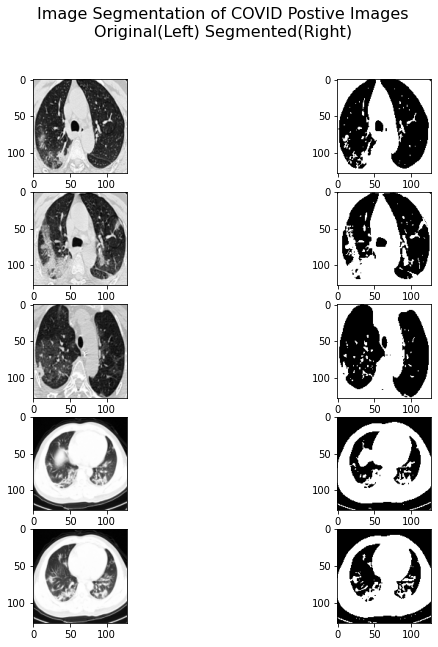

In [140]:
# show results for positive scans
fig, ax = plt.subplots(5, 2, figsize=(10, 10))
for i, seg in enumerate(pos_data_seg):
    if i == 5:
        break
    ax[i, 0].imshow(pos_data[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(seg.squeeze(), cmap='gray')
fig.suptitle('Image Segmentation of COVID Postive Images\nOriginal(Left) Segmented(Right)', fontsize=16)
plt.show()

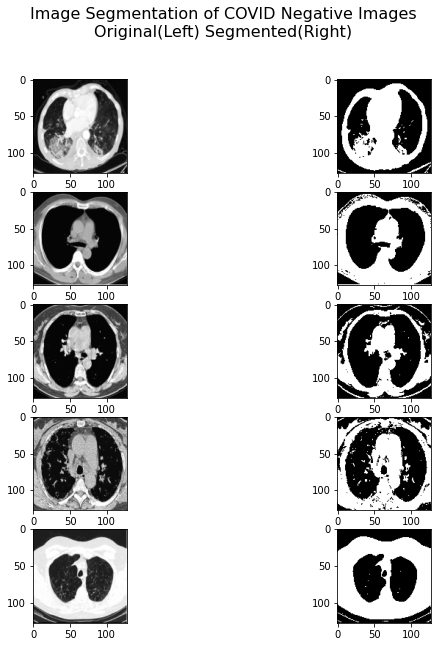

In [141]:
# show results for negtive 
fig, ax = plt.subplots(5, 2, figsize=(10, 10))
for i, seg in enumerate(neg_data_seg):
    if i == 5:
        break
    ax[i, 0].imshow(neg_data[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(seg.squeeze(), cmap='gray')
fig.suptitle('Image Segmentation of COVID Negative Images\nOriginal(Left) Segmented(Right)', fontsize=16)
plt.show()

In [142]:
x_data = pos_data_seg + neg_data_seg 
x_data = np.array(x_data, dtype='float32')
print(pos_data.shape)
print(neg_data.shape)
y_data = [1]*len(pos_data_seg) + [0]*len(neg_data_seg)
y_data = np.array(y_data, dtype='float32')
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2)

(349, 128, 128, 1)
(397, 128, 128, 1)


In [143]:
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=15, verbose=1, mode='auto')

In [144]:

from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

vgg = VGG16(include_top=False, input_shape=(128, 128, 3), weights='imagenet', pooling='avg')
for layer in vgg.layers[:-4]:
    layer.trainable = False
out_layer = Dense(1, activation='sigmoid')(vgg.layers[-1].output)
model_pre_vgg = Model(vgg.input, out_layer)
opt = SGD(lr=1e-5)
model_pre_vgg.compile(optimizer=opt, loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

In [145]:
# model summary
model_pre_vgg.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)     

In [146]:
# load images in RGB-scale without normalisation
DIR = "/content/drive/MyDrive/ct scan classification"
img_height = 128
img_width = 128
train_datagen_pre_vgg = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    validation_split=0.2) 

train_generator_pre_vgg = train_datagen_pre_vgg.flow_from_directory(
    DIR,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode="rgb",
    subset='training') 

validation_generator_pre_vgg = train_datagen_pre_vgg.flow_from_directory(
    DIR, 
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode="rgb",
    subset='validation') 

Found 598 images belonging to 2 classes.
Found 148 images belonging to 2 classes.


In [147]:
# train model
batch_size = 32
epochs = 50
history_pre_vgg = model_pre_vgg.fit_generator(train_generator_pre_vgg, steps_per_epoch = train_generator_pre_vgg.samples // batch_size,
        validation_data = validation_generator_pre_vgg, validation_steps = validation_generator_pre_vgg.samples // batch_size,
        epochs=epochs, callbacks=[early])

Epoch 1/50
18/18 [==============================] - 3s 174ms/step - loss: 2.7057 - accuracy: 0.4826 - val_loss: 1.6633 - val_accuracy: 0.6406
Epoch 2/50
18/18 [==============================] - 3s 161ms/step - loss: 2.6429 - accuracy: 0.4792 - val_loss: 2.5991 - val_accuracy: 0.5469
Epoch 3/50
18/18 [==============================] - 3s 160ms/step - loss: 2.6462 - accuracy: 0.4748 - val_loss: 2.6032 - val_accuracy: 0.5156
Epoch 4/50
18/18 [==============================] - 3s 154ms/step - loss: 2.2591 - accuracy: 0.5360 - val_loss: 2.5689 - val_accuracy: 0.5469
Epoch 5/50
18/18 [==============================] - 3s 159ms/step - loss: 2.3755 - accuracy: 0.5347 - val_loss: 1.7282 - val_accuracy: 0.6562
Epoch 6/50
18/18 [==============================] - 3s 154ms/step - loss: 2.2671 - accuracy: 0.5382 - val_loss: 1.9068 - val_accuracy: 0.6094
Epoch 7/50
18/18 [==============================] - 3s 159ms/step - loss: 1.7482 - accuracy: 0.5504 - val_loss: 2.6530 - val_accuracy: 0.5781
Epoch 

Text(0.5, 0, 'epoch')

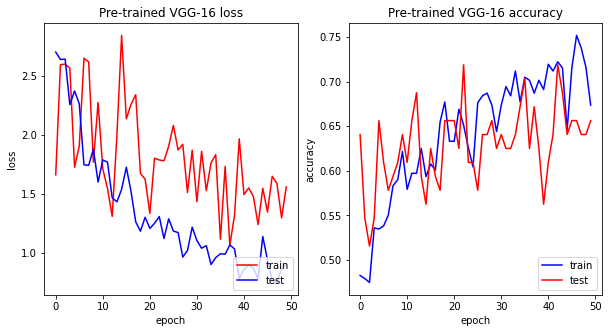

In [159]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].set_title('Pre-trained VGG-16 loss')
ax[0].plot(history_pre_vgg.history['val_loss'], 'r')
ax[0].plot(history_pre_vgg.history['loss'], 'b')
ax[0].legend(['train', 'test'], loc='lower right')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')

ax[1].set_title('Pre-trained VGG-16 accuracy')
ax[1].plot(history_pre_vgg.history['accuracy'], 'b')
ax[1].plot(history_pre_vgg.history['val_accuracy'], 'r')
ax[1].legend(['train', 'test'], loc='lower right')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')